# understanding AG pair reactivity trends

# Summary

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from tabulate import tabulate

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    plot_motif_boxplot_stripplot,
    plot_violins_w_percent,
    plot_violins_w_percent_groups,
    format_small_plot,
)
from dms_3d_features.format_tables import (
    dataframe_column_table,
    generate_threshold_summary,
)
from dms_3d_features.stats import r2

## extra functions

### plotting

In [2]:
def plot_residue_trends(df, color="tab:gray"):
    fig = plt.figure(figsize=(3.0, 3.0), dpi=200)
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[:, 1])

    # 5' Residue
    data_range = df["ln_r_data"].max() - df["ln_r_data"].min()
    extra_space = 0.4 * data_range
    xlim_min = df["ln_r_data"].min() - extra_space
    xlim_max = df["ln_r_data"].max()

    plot_violins_w_percent(
        df,
        "ln_r_data",
        "p5_res",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax1,
    )
    ax1.set_ylabel("5' Residue", labelpad=2)
    ax1.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    format_small_plot(ax1)

    # 3' Residue
    plot_violins_w_percent(
        df,
        "ln_r_data",
        "p3_res",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax2,
    )
    ax2.set_ylabel("3' Residue", labelpad=2)
    ax2.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    format_small_plot(ax2)

    # Residue Stack
    plot_violins_w_percent(
        df,
        "ln_r_data",
        "r_stack",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax3,
    )
    ax3.set_ylabel("Residue Stack", labelpad=2)
    ax3.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    format_small_plot(ax3)
    plt.tight_layout()

### summary tables

In [3]:
def create_summary_table(df, y_column):
    # Calculate percentages and counts
    summary = []
    for y_value in df[y_column].unique():
        group = df[df[y_column] == y_value]
        percent_over = (group["ln_r_data"] < -5.45).mean() * 100
        count = len(group)
        summary.append([y_value, f"{percent_over:.2f}%", count])

    # Sort by percentage descending
    summary.sort(key=lambda x: float(x[1][:-1]), reverse=True)

    # Create table
    headers = [y_column, "% Under -5.45", "Count"]
    table = tabulate(summary, headers=headers, tablefmt="pipe", floatfmt=".2f")

    print(f"Summary table for {y_column}:")
    print(table)

### misc

In [4]:
def assign_stack_type(row):
    if row["both_pyrimidine"]:
        return "both_pyrimidine"
    elif row["both_purine"]:
        return "both_purine"
    else:
        return "mixed"

In [5]:
def add_side_diff_column(df):
    df["side_diff"] = [
        abs(int(x.split("x")[0]) - int(x.split("x")[1])) for x in df["m_token"]
    ]
    df["side_diff"] = df["side_diff"].astype(str)
    return df

## load data

In [6]:
DATA_PATH = "../data"

In [7]:
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df_ag = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AG'").copy()
# pdb dataframe
df_pdb = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_pdb.json")
df_pdb_ag = df_pdb.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and pdb_r_pair == 'A-G' and no_of_interactions == 1"
).copy()

In [8]:
df_bfact = pd.read_csv(f"../data/pdb-features/b_factor.csv")
df_bfact = df_bfact[
    ["pdb_name", "pdb_r_pos", "average_b_factor", "normalized_b_factor"]
]
df_pdb_ag = df_pdb_ag.merge(df_bfact, on=["pdb_name", "pdb_r_pos"]).copy()

In [9]:
df_pdb_ag.iloc[0]

m_sequence                                                            AAAG_CGAU
r_nuc                                                                         A
pdb_r_pos                                                                     5
partner_nuc                                                                None
pdb_partner_pos                                                             NaN
r_type                                                                   NON-WC
pdb_r_bp_type                                                               tHS
pdb_r_pair                                                                  A-G
no_of_conformations                                                           1
no_of_interactions                                                            1
no_of_partner_interactions                                                    1
pdb_name                                        TWOWAY.5O5J.2-2.AAAG-CGAU.0.pdb
pdb_path                      data/pdbs_

In [10]:
df_pdb_ag_sub = df_pdb_ag.dropna(subset=["pdb_path", "pdb_r_bp_type", "ln_r_data"])
df_sub_1 = (
    df_pdb_ag_sub.groupby("pdb_r_bp_type")
    .agg(
        ln_r_data_min=("ln_r_data", "min"),
        ln_r_data_max=("ln_r_data", "max"),
    )
    .reset_index()
)

data = []
for i, g in df_pdb_ag_sub.groupby("pdb_r_bp_type"):
    row_min = g.loc[g["ln_r_data"].idxmin()]
    row_max = g.loc[g["ln_r_data"].idxmax()]
    data.append([i, row_min["pdb_path"], row_max["pdb_path"]])
df_sub_2 = pd.DataFrame(data)
df_sub_2.columns = ["pdb_r_bp_type", "min_pdb_path", "max_pdb_path"]
df_sub_final = pd.merge(
    df_sub_1, df_sub_2, left_on="pdb_r_bp_type", right_on="pdb_r_bp_type", how="left"
)

# Format the DataFrame as a tabulate table
table = tabulate(df_sub_final, headers="keys", tablefmt="pipe", showindex=False)

# Print the formatted table
print(table)

| pdb_r_bp_type   |   ln_r_data_min |   ln_r_data_max | min_pdb_path                                                        | max_pdb_path                                                      |
|:----------------|----------------:|----------------:|:--------------------------------------------------------------------|:------------------------------------------------------------------|
| cHS             |        -6.35963 |       -3.6601   | data/pdbs_w_2bp/GAAAU_ACAC/TWOWAY.4YAZ.2-3.ACAC-GAAAU.1.pdb         | data/pdbs_w_2bp/GAAAU_ACAC/TWOWAY.4YAZ.2-3.ACAC-GAAAU.1.pdb       |
| cSH             |        -4.65541 |       -3.65313  | data/pdbs_w_2bp/GAAG_CAC/TWOWAY.6DME.1-2.CAC-GAAG.0.pdb             | data/pdbs_w_2bp/GAAG_CAC/TWOWAY.6DME.1-2.CAC-GAAG.0.pdb           |
| cSS             |        -4.06985 |       -2.14353  | data/pdbs_w_2bp/CAUAG_CG/NWAY.2GJW.0-0-0-0.CA-AG-DU-CG.0.pdb        | data/pdbs_w_2bp/CAUAG_CG/NWAY.2GJW.0-0-0-0.CA-AG-DU-CG.0.pdb      |
| cSW             |        -7.

In [11]:
dataframe_column_table(df_pdb)

                  0                  1                          2                    3
         m_sequence              r_nuc                  pdb_r_pos          partner_nuc
    pdb_partner_pos             r_type              pdb_r_bp_type           pdb_r_pair
no_of_conformations no_of_interactions no_of_partner_interactions             pdb_name
           pdb_path            pdb_res                both_purine      both_pyrimidine
         constructs        likely_pair              m_flank_bp_5p        m_flank_bp_3p
      m_orientation              m_pos       m_second_flank_bp_5p m_second_flank_bp_3p
        m_structure            m_token                     n_pdbs            pair_type
             p5_res            p5_type                     p3_res              p3_type
             r_data          r_loc_pos                      r_pos              r_stack
          ln_r_data            z_score             r_data_outlier       pair_pdb_r_pos


# All residues

In [12]:
df_ag = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AG'").copy()
print(len(df_ag["m_sequence"].unique()))

340


In [13]:
df_ag = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AG'").copy()
generate_threshold_summary(df_ag, "r_nuc", greater_than=False)

Summary table for r_nuc:
| r_nuc   | % < -5.45   |   Count |
|:--------|:------------|--------:|
| A       | 19.26%      |   16995 |


In [14]:
df_ag = df.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AG' and m_token == '1x1'"
).copy()
generate_threshold_summary(df_ag, "r_nuc", greater_than=False)

Summary table for r_nuc:
| r_nuc   | % < -5.45   |   Count |
|:--------|:------------|--------:|
| A       | 29.31%      |     563 |


### Stacking trends

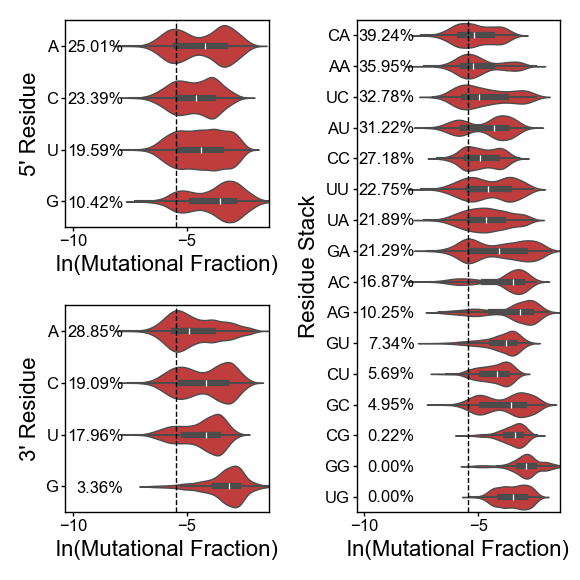

In [15]:
df_ag = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AG'").copy()
plot_residue_trends(df_ag, color="tab:red")

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


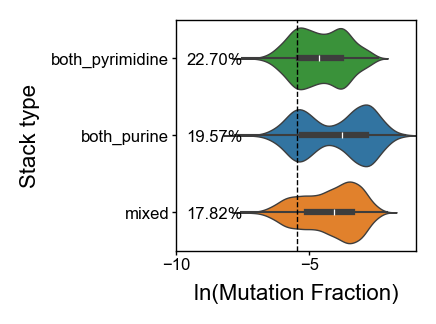

In [16]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_ag = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AG'").copy()
df_ag["stack_type"] = df_ag.apply(assign_stack_type, axis=1)
ax = plot_violins_w_percent(
    df_ag,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
format_small_plot(ax)

In [17]:
df_ag = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AG'").copy()
create_summary_table(df_ag, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CA        | 39.24%          |    1213 |
| AA        | 35.95%          |    1708 |
| UC        | 32.78%          |     778 |
| AU        | 31.22%          |    1118 |
| CC        | 27.18%          |     710 |
| UU        | 22.75%          |     835 |
| UA        | 21.89%          |    1608 |
| GA        | 21.29%          |    1794 |
| AC        | 16.87%          |    1091 |
| AG        | 10.25%          |    1132 |
| GU        | 7.34%           |    1022 |
| CU        | 5.69%           |     650 |
| GC        | 4.95%           |     989 |
| CG        | 0.22%           |     450 |
| GG        | 0.00%           |    1049 |
| UG        | 0.00%           |     848 |


# single mismatches

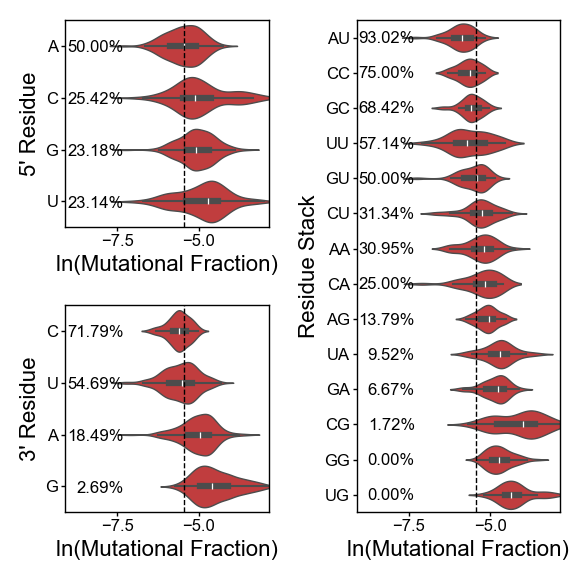

In [18]:
df_ag_1x1 = df.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AG' and m_token == '1x1'"
).copy()
plot_residue_trends(df_ag_1x1, color="tab:red")

In [19]:
create_summary_table(df_ag_1x1, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| AU        | 93.02%          |      43 |
| CC        | 75.00%          |      20 |
| GC        | 68.42%          |      19 |
| UU        | 57.14%          |      42 |
| GU        | 50.00%          |      40 |
| CU        | 31.34%          |      67 |
| AA        | 30.95%          |      42 |
| CA        | 25.00%          |      32 |
| AG        | 13.79%          |      29 |
| UA        | 9.52%           |      42 |
| GA        | 6.67%           |      30 |
| CG        | 1.72%           |      58 |
| UG        | 0.00%           |      37 |
| GG        | 0.00%           |      62 |


/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


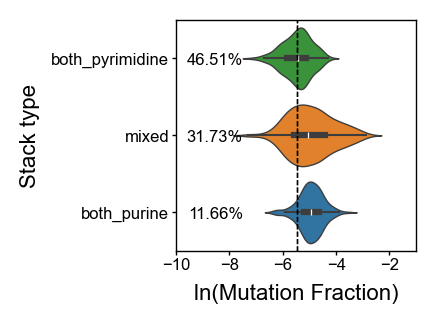

In [20]:
df_ag_1x1 = df.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AG' and m_token == '1x1'"
).copy()
df_ag_1x1["stack_type"] = df_ag_1x1.apply(assign_stack_type, axis=1)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
ax = plot_violins_w_percent(
    df_ag_1x1,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_xlim(-10, -1)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
format_small_plot(ax)

# 2x2 double mismatches

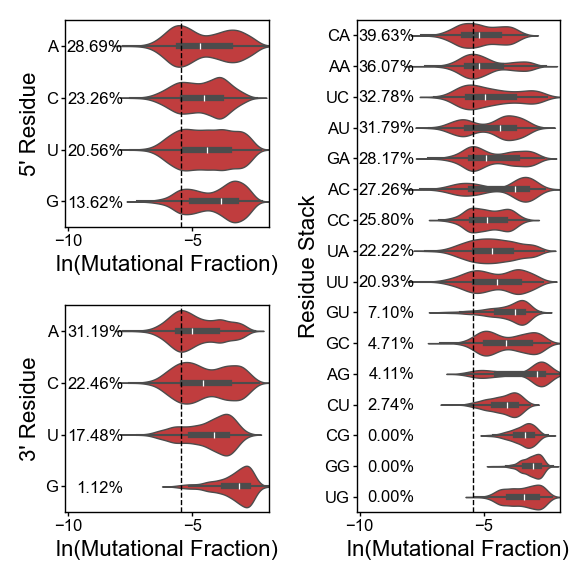

In [21]:
df_ag_2x2 = df.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AG' and m_token == '2x2'"
).copy()
plot_residue_trends(df_ag_2x2, color="tab:red")

In [22]:
create_summary_table(df_ag_2x2, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CA        | 39.63%          |    1181 |
| AA        | 36.07%          |    1666 |
| UC        | 32.78%          |     778 |
| AU        | 31.79%          |     972 |
| GA        | 28.17%          |    1349 |
| AC        | 27.26%          |     675 |
| CC        | 25.80%          |     690 |
| UA        | 22.22%          |    1566 |
| UU        | 20.93%          |     793 |
| GU        | 7.10%           |     775 |
| GC        | 4.71%           |     764 |
| AG        | 4.11%           |     584 |
| CU        | 2.74%           |     583 |
| CG        | 0.00%           |     392 |
| GG        | 0.00%           |     571 |
| UG        | 0.00%           |     604 |


# with PDB info with known pairs

## stacking

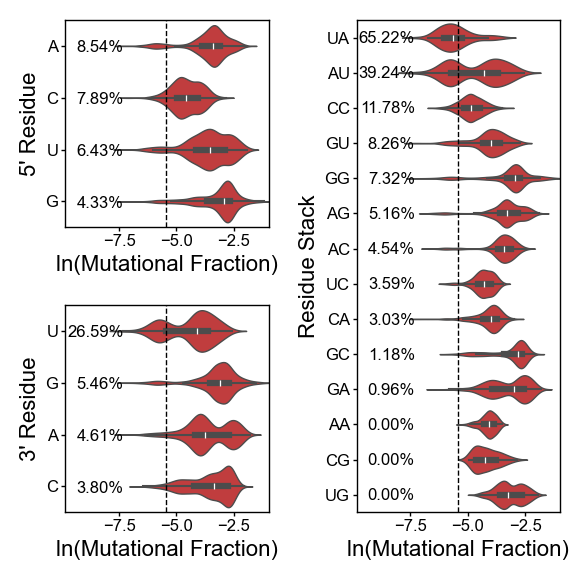

In [23]:
df_pdb_ag = df_pdb.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and pdb_r_pair == 'A-G' and no_of_interactions == 1"
).copy()
plot_residue_trends(df_pdb_ag, color="tab:red")

In [24]:
create_summary_table(df_pdb_ag, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| UA        | 65.22%          |      69 |
| AU        | 39.24%          |     316 |
| CC        | 11.78%          |     365 |
| GU        | 8.26%           |     218 |
| GG        | 7.32%           |    2076 |
| AG        | 5.16%           |    1317 |
| AC        | 4.54%           |     904 |
| UC        | 3.59%           |     167 |
| CA        | 3.03%           |     165 |
| GC        | 1.18%           |    1354 |
| GA        | 0.96%           |     831 |
| CG        | 0.00%           |      78 |
| UG        | 0.00%           |     557 |
| AA        | 0.00%           |     192 |
|           | nan%            |       0 |


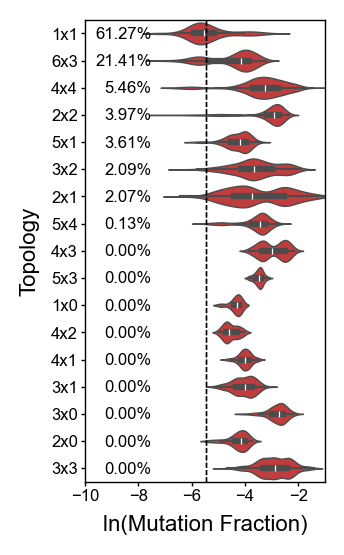

In [25]:
fig, ax = plt.subplots(figsize=(2.0, 3.0), dpi=200)
ax = plot_violins_w_percent(
    df_pdb_ag,
    "ln_r_data",
    "m_token",
    color="tab:red",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_xlim(-10, -1)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_ylabel("Topology")
ax.set_xlabel("ln(Mutation Fraction)")
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
format_small_plot(ax)

In [26]:
df_pdb_ag.query("m_token.isnull()")

,m_sequence,r_nuc,pdb_r_pos,partner_nuc,pdb_partner_pos,r_type,pdb_r_bp_type,pdb_r_pair,no_of_conformations,no_of_interactions,...,p3_res,p3_type,r_data,r_loc_pos,r_pos,r_stack,ln_r_data,z_score,r_data_outlier,pair_pdb_r_pos
55610,GGUAC_GGGC,A,6,None,NaN,NON-WC,cWW,A-G,2,1,...,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,13
55613,GGUAC_GGGC,A,6,None,NaN,NON-WC,cWW,A-G,2,1,...,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,13
55616,GGUAC_GGGC,A,6,None,NaN,NON-WC,cSH,A-G,2,1,...,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,13
55619,GGUAC_GGGC,A,6,None,NaN,NON-WC,cWW,A-G,2,1,...,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,13
55622,GGUAC_GGGC,A,6,None,NaN,NON-WC,cSH,A-G,2,1,...,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,13


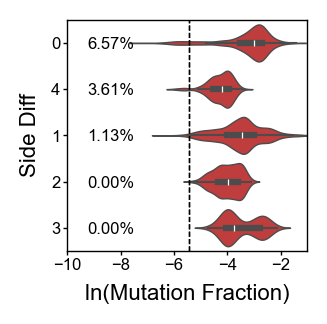

In [27]:
df_pdb_ag = df_pdb_ag.query("not m_token.isnull()")
df_pdb_ag = df_pdb_ag.query("m_token != '6x3'")
df_pdb_ag.query("m_token.isnull()")
df_pdb_ag = add_side_diff_column(df_pdb_ag)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
ax = plot_violins_w_percent(
    df_pdb_ag,
    "ln_r_data",
    "side_diff",
    color="tab:red",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_xlim(-10, -1)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_ylabel("Side Diff")
ax.set_xlabel("ln(Mutation Fraction)")
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
format_small_plot(ax)

In [28]:
df_pdb_ag.groupby("pdb_r_bp_type").agg(
    avg_ln_r_data=("ln_r_data", "mean"),
    std_ln_r_data=("ln_r_data", "std"),
    count=("ln_r_data", "size"),
).reset_index()

,pdb_r_bp_type,avg_ln_r_data,std_ln_r_data,count
0,cHS,-4.694636,0.514244,76
1,cSH,-4.030251,0.222113,92
2,cSS,-2.797838,0.364950,63
3,cSW,-5.597437,0.481576,30
4,cWH,-4.885626,1.412749,151
5,cWS,-4.277950,0.356355,25
6,cWW,-4.425277,1.116741,1490
7,tHH,-2.725834,0.293888,52
8,tHS,-3.040804,0.539188,5501
9,tSH,-2.424800,0.249483,82


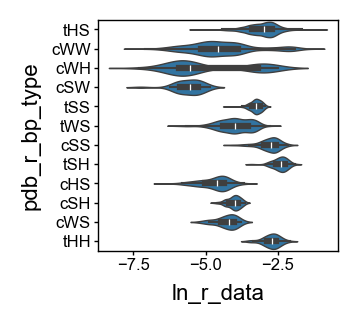

In [29]:
fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)
sns.violinplot(
    data=df_pdb_ag,
    y="pdb_r_bp_type",
    x="ln_r_data",
    density_norm="width",
    ax=ax,
    linewidth=0.5,
)
format_small_plot(ax)

In [30]:
row = df_pdb_ag.iloc[df["ln_r_data"].idxmin()]
row

IndexError: single positional indexer is out-of-bounds

In [59]:
df_pdb_ag_sub = df_pdb_ag.dropna(subset=["pdb_path", "pdb_r_bp_type", "ln_r_data"])
df_sub_1 = (
    df_pdb_ag_sub.groupby("pdb_r_bp_type")
    .agg(
        ln_r_data_min=("ln_r_data", "min"),
        ln_r_data_max=("ln_r_data", "max"),
    )
    .reset_index()
)

data = []
for i, g in df_pdb_ag_sub.groupby("pdb_r_bp_type"):
    row_min = g.loc[g["ln_r_data"].idxmin()]
    row_max = g.loc[g["ln_r_data"].idxmax()]
    data.append([i, row_min["pdb_path"], row_max["pdb_path"]])
df_sub_2 = pd.DataFrame(data)
df_sub_2.columns = ["pdb_r_bp_type", "min_pdb_path", "max_pdb_path"]
df_sub_final = pd.merge(
    df_sub_1, df_sub_2, left_on="pdb_r_bp_type", right_on="pdb_r_bp_type", how="left"
)

# Format the DataFrame as a tabulate table
table = tabulate(df_sub_final, headers="keys", tablefmt="pipe", showindex=False)

# Print the formatted table
print(table)

| pdb_r_bp_type   |   ln_r_data_min |   ln_r_data_max | min_pdb_path                                                         | max_pdb_path                                                      |
|:----------------|----------------:|----------------:|:---------------------------------------------------------------------|:------------------------------------------------------------------|
| cHS             |        -6.35963 |       -3.6601   | data/pdbs_w_2bp/GAAAU_ACAC/TWOWAY.4YAZ.2-3.ACAC-GAAAU.1.pdb          | data/pdbs_w_2bp/GAAAU_ACAC/TWOWAY.4YAZ.2-3.ACAC-GAAAU.1.pdb       |
| cSH             |        -4.65541 |       -3.65313  | data/pdbs_w_2bp/GAAG_CAC/TWOWAY.6DME.1-2.CAC-GAAG.0.pdb              | data/pdbs_w_2bp/GAAG_CAC/TWOWAY.6DME.1-2.CAC-GAAG.0.pdb           |
| cSS             |        -4.06985 |       -2.14353  | data/pdbs_w_2bp/CAUAG_CG/NWAY.2GJW.0-0-0-0.CA-AG-DU-CG.0.pdb         | data/pdbs_w_2bp/CAUAG_CG/NWAY.2GJW.0-0-0-0.CA-AG-DU-CG.0.pdb      |
| cSW             |      

In [73]:
df_dist = pd.read_csv("../data/pdb-features/distances_all.csv")

In [115]:
def calculate_atom_distances(df_pdb_ag, df_dist, r_atom, pair_atom):
    data = []
    for i, g in df_pdb_ag.groupby(["pdb_name", "pdb_r_pos"]):
        row = g.iloc[0]
        if row["pair_pdb_r_pos"] == -1:
            continue
        if row.pdb_r_pos < row.pair_pdb_r_pos:
            df_sub = df_dist.query(
                f'pdb_name == "{row.pdb_name}" and '
                f"res_num1 == {row.pdb_r_pos} and res_num2 == {row.pair_pdb_r_pos} and "
                f'atom_name1 == "{r_atom}" and atom_name2 == "{pair_atom}"'
            )
        else:
            df_sub = df_dist.query(
                f'pdb_name == "{row.pdb_name}" and '
                f"res_num1 == {row.pair_pdb_r_pos} and res_num2 == {row.pdb_r_pos} and "
                f'atom_name1 == "{pair_atom}" and atom_name2 == "{r_atom}"'
            )
        if len(df_sub) == 0:
            print("couldnt find distance")
            continue
        data.append(
            {
                "pdb_name": row.pdb_path,
                "pdb_r_pos": row.pdb_r_pos,
                "pair_pdb_r_pos": row.pair_pdb_r_pos,
                "pdb_r_bp_type": row.pdb_r_bp_type,
                "distance": df_sub.iloc[0]["distance"],
                "pdb_res": row.pdb_res,
                "ln_r_data_mean": g["ln_r_data"].mean(),
                "ln_r_data_std": g["ln_r_data"].std(),
            }
        )
    return pd.DataFrame(data)


# Example usage:
df_dist_ag = calculate_atom_distances(df_pdb_ag, df_dist, "P", "P")

In [116]:
len(df_dist_ag)

113

In [80]:
df_dist_ag.sort_values("distance", ascending=True, inplace=True)
print(tabulate(df_dist_ag.head(10), headers="keys", tablefmt="psql"))

+-----+-------------------------------------------------------------------+-------------+------------------+-----------------+------------+-----------+------------------+-----------------+
|     | pdb_name                                                          |   pdb_r_pos |   pair_pdb_r_pos | pdb_r_bp_type   |   distance |   pdb_res |   ln_r_data_mean |   ln_r_data_std |
|-----+-------------------------------------------------------------------+-------------+------------------+-----------------+------------+-----------+------------------+-----------------|
|  99 | data/pdbs_w_2bp/UGAGG_UGGAG/TWOWAY.6YS3.3-3.UGAGG-UGGAG.0.pdb     |           5 |               14 | tHS             |      12.82 |      2.58 |         -1.88021 |        0.30005  |
|  51 | data/pdbs_w_2bp/GGGAAC_GGGAAC/TWOWAY.3FTF.4-4.GGGAAC-GGGAAC.0.pdb |           6 |               15 | tHS             |      12.83 |      2.8  |         -2.84882 |        0.264305 |
|  47 | data/pdbs_w_2bp/GGGAAC_GGGAAC/TWOWAY.3FTE.4-4.G

Text(0.5, 1.0, 'Distance N1 vs Mean ln(r_data) (R² = 0.616)')

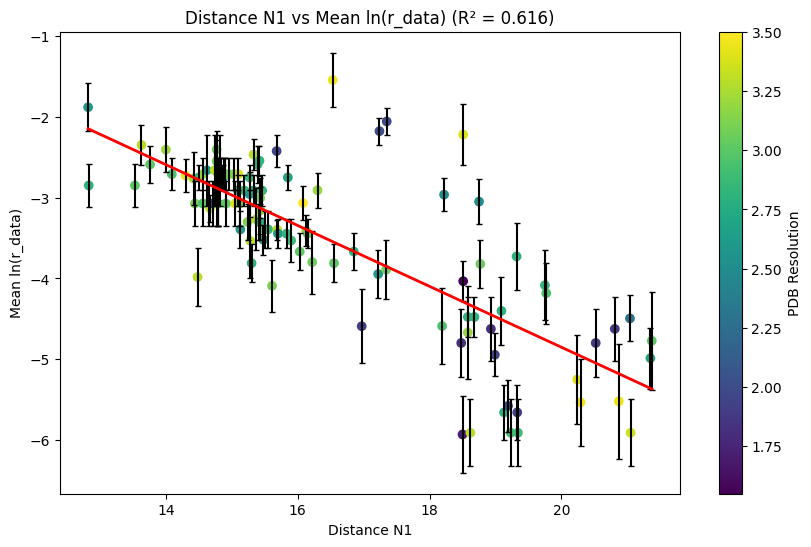

In [82]:
# Prepare the data
X = df_dist_ag["distance"].values.reshape(-1, 1)
y = df_dist_ag["ln_r_data_mean"].values
y_err = df_dist_ag["ln_r_data_std"].values

# Remove any rows with NaN values
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y) & ~np.isnan(y_err)
X = X[mask]
y = y[mask]
y_err = y_err[mask]
pdb_res = df_dist_ag["pdb_res"].values[mask]

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Compute R-squared
r2 = r2_score(y, model.predict(X))

# Create scatter plot with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(X.flatten(), y, yerr=y_err, fmt="none", ecolor="black", capsize=2)
scatter = plt.scatter(X.flatten(), y, c=pdb_res, cmap="viridis")
cbar = plt.colorbar(scatter)
cbar.set_label("PDB Resolution")

# Add regression line
plt.plot(X, model.predict(X), color="red", linewidth=2)

plt.xlabel("Distance N1")
plt.ylabel("Mean ln(r_data)")
plt.title(f"Distance N1 vs Mean ln(r_data) (R² = {r2:.3f})")

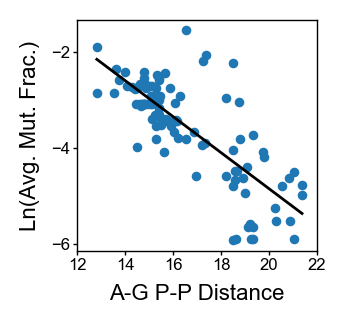

In [110]:
# Prepare the data
X = df_dist_ag["distance"].values.reshape(-1, 1)
y = df_dist_ag["ln_r_data_mean"].values
y_err = df_dist_ag["ln_r_data_std"].values

# Remove any rows with NaN values
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y) & ~np.isnan(y_err)
X = X[mask]
y = y[mask]
y_err = y_err[mask]
pdb_res = df_dist_ag["pdb_res"].values[mask]

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Compute R-squared
r2 = r2_score(y, model.predict(X))

# Create scatter plot with error bars
fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)
# ax.errorbar(X.flatten(), y, yerr=y_err, fmt="none", ecolor="black", capsize=1)
ax.scatter(X.flatten(), y, s=6)

# Add regression line
ax.plot(X, model.predict(X), color="black", linewidth=1)

ax.set_xlabel("A-G P-P Distance")
ax.set_ylabel("Ln(Avg. Mut. Frac.)")
ax.set_xticks([12, 14, 16, 18, 20, 22])
format_small_plot(ax)

In [91]:
print(df_dist_ag.iloc[0]["pdb_name"])
print(df_dist_ag.iloc[0]["pdb_r_pos"])
print(df_dist_ag.iloc[0]["distance"])
print(df_dist_ag.iloc[0]["ln_r_data_mean"])

data/pdbs_w_2bp/UGAGG_UGGAG/TWOWAY.6YS3.3-3.UGAGG-UGGAG.0.pdb
5
12.82
-1.880208474629808


In [92]:
print(df_dist_ag.iloc[80]["pdb_name"])
print(df_dist_ag.iloc[80]["pdb_r_pos"])
print(df_dist_ag.iloc[80]["distance"])
print(df_dist_ag.iloc[80]["ln_r_data_mean"])

data/pdbs_w_2bp/GGGAGC_GGGAGC/TWOWAY.1D4R.4-4.GGGAGC-GGGAGC.0.pdb
16
17.35
-2.0557899661442303


In [93]:
print(df_dist_ag.iloc[-1]["pdb_name"])
print(df_dist_ag.iloc[-1]["pdb_r_pos"])
print(df_dist_ag.iloc[-1]["distance"])
print(df_dist_ag.iloc[-1]["ln_r_data_mean"])

data/pdbs_w_2bp/GCAC_GGAU/TWOWAY.6ZVI.2-2.GGAU-GCAC.0.pdb
5
21.37
-4.771719045775


Text(0.5, 1.0, 'Distance N1 vs Mean ln(r_data) (R² = 0.402)')

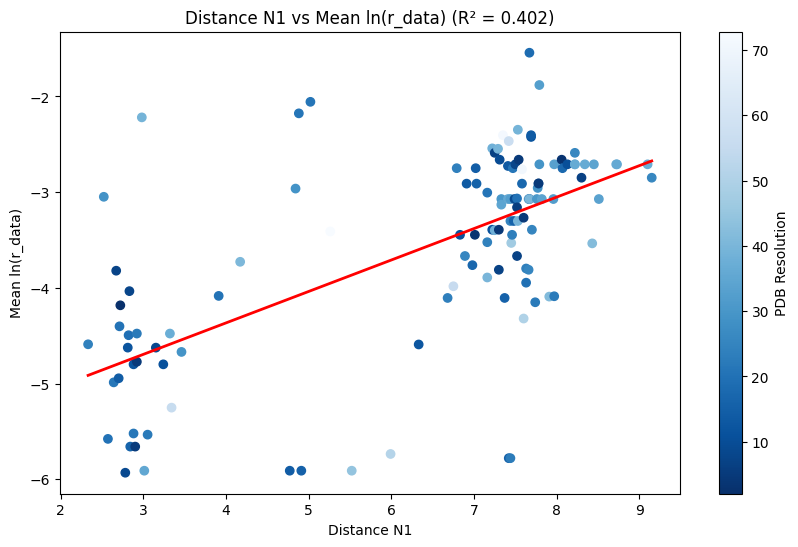

In [ ]:
# Prepare the data
X = df_dist_ag["distance"].values.reshape(-1, 1)
y = df_dist_ag["ln_r_data_mean"].values
y_err = df_dist_ag["ln_r_data_std"].values

# Remove any rows with NaN values
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y) & ~np.isnan(y_err)
X = X[mask]
y = y[mask]
y_err = y_err[mask]
pdb_res = df_dist_ag["normalized_b_factor"][mask]

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Compute R-squared
r2 = r2_score(y, model.predict(X))

# Create scatter plot with error bars
plt.figure(figsize=(10, 6))
# plt.errorbar(X.flatten(), y, yerr=y_err, fmt='none', ecolor='black', capsize=2)
scatter = plt.scatter(X.flatten(), y, c=pdb_res, cmap="Blues_r")
cbar = plt.colorbar(scatter)
cbar.set_label("PDB Resolution")

# Add regression line
plt.plot(X, model.predict(X), color="red", linewidth=2)

plt.xlabel("Distance N1")
plt.ylabel("Mean ln(r_data)")
plt.title(f"Distance N1 vs Mean ln(r_data) (R² = {r2:.3f})")

In [ ]:
# Create a function to compute R-squared and count points for a given PDB resolution cutoff
def compute_r2_and_count_for_cutoff(df, cutoff):
    mask = (
        (df["pdb_res"] <= cutoff)
        & (~df["pdb_res"].isna())
        & (~df["ln_r_data_mean"].isna())
    )
    X = df.loc[mask, "distance"].values.reshape(-1, 1)
    y = df.loc[mask, "ln_r_data_mean"].values

    if len(X) < 2:  # Need at least two points for regression
        return np.nan, 0

    model = LinearRegression()
    model.fit(X, y)
    return r2_score(y, model.predict(X)), len(X)


# Define PDB resolution cutoffs
cutoffs = [1.5, 1.80, 2.0, 2.5, 3.0, 3.5, float("inf")]

# Compute R-squared and count points for each cutoff
results = []
for cutoff in cutoffs:
    r2, count = compute_r2_and_count_for_cutoff(df_dist_ag, cutoff)
    results.append({"Cutoff": cutoff, "R-squared": r2, "Count": count})

table_data = [
    [
        f"≤ {cutoff:.1f}" if cutoff != float("inf") else "All",
        f"{r2:.3f}" if not np.isnan(r2) else "N/A",
        f"{count}",
    ]
    for cutoff, r2, count in zip(
        cutoffs, [r["R-squared"] for r in results], [r["Count"] for r in results]
    )
]

print(
    tabulate(
        table_data,
        headers=["PDB Resolution Cutoff", "R-squared", "Number of Points"],
        tablefmt="pipe",
    )
)

| PDB Resolution Cutoff   | R-squared   |   Number of Points |
|:------------------------|:------------|-------------------:|
| ≤ 1.5                   | N/A         |                  0 |
| ≤ 1.8                   | 0.733       |                  6 |
| ≤ 2.0                   | 0.537       |                 15 |
| ≤ 2.5                   | 0.427       |                 18 |
| ≤ 3.0                   | 0.549       |                 67 |
| ≤ 3.5                   | 0.516       |                113 |
| All                     | 0.516       |                113 |


In [ ]:
pair_atoms = list(df_dist.query("res_name1 == 'G'")["atom_name1"].unique())

In [ ]:
for pair_atom in pair_atoms:
    df_dist_ag = calculate_atom_distances(df_pdb_ag, df_dist, "N1", pair_atom)
    df_dist_ag.dropna(inplace=True)
    r2_val = pearsonr(df_dist_ag["distance"], df_dist_ag["ln_r_data_mean"])[0] ** 2
    df_dist_ag_sub = df_dist_ag.query("pdb_res < 2.0")
    r2_val_sub = (
        pearsonr(df_dist_ag_sub["distance"], df_dist_ag_sub["ln_r_data_mean"])[0] ** 2
    )
    print(pair_atom, r2_val, len(df_dist_ag), r2_val_sub, len(df_dist_ag_sub))

N1 0.5156669178951985 113 0.6982387971498288 12
O6 0.624710539490687 55 0.7482903058262791 7
C2 0.36158672296420363 113 0.49148755620511153 12
N2 0.12703047895739053 56 0.7361361777633701 7
C6 0.4402155951561809 113 0.6727593324261829 12
N3 0.1778641530284875 113 0.15679457891700022 12
C4 0.3722245295348903 113 0.22865101537759092 12
C5 0.35907386829977345 113 0.5104644711688122 12
N7 0.03948855860615908 113 0.16152565338052813 12
N9 0.028695115721314265 113 0.013662107233127729 12
C1' 0.01908391569747117 111 0.33609305961411107 11
C2' 0.015658714825778845 108 0.23938418208451587 11
C8 0.0007625044586024314 113 0.00044960165899590883 12
O4' 0.22975091056022148 109 0.6219926927758893 11
C3' 0.10107982846740815 106 0.4074162786997547 11
O2' 0.4770617014149256 71 0.7038616960964941 10
C4' 0.1397479144515475 97 0.5733060923001457 7
C5' 0.21515179695097802 83 0.5504580356800642 3
O3' 0.14688666260435254 63 0.7166236865390031 5
O5' 0.21093870022551847 81 0.43945297310573794 4


ValueError: x and y must have length at least 2.